In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import pymc3 as pm

In [7]:
with open('UQ_final_data/maunaloa.co2.txt', 'r') as f:
    co2_file = f.read().splitlines()

In [8]:
full_co2_data = []
for year_data in co2_file[22:39+22]:
    for val in year_data.split()[1:-1]:
        full_co2_data.append(val)

In [9]:
len(full_co2_data) / 12

39.0

In [10]:
full_co2_data = np.array(full_co2_data).astype('float32')

In [11]:
y_res = np.array([i for i in range(len(full_co2_data))])

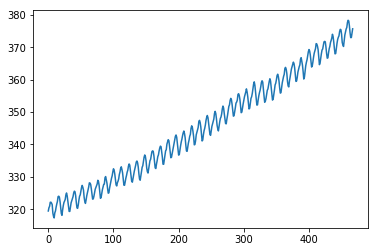

In [12]:
plt.plot(y_res, full_co2_data)

In [2]:
f = h5py.File('UQ_final_data/co2_data.h5', 'r')

In [4]:
data_train = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()

In [6]:
X_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)
print(data_train.shape)

X_test = np.arange(-1.72, 3.51, 0.01).reshape(-1, 1)

(272, 2)


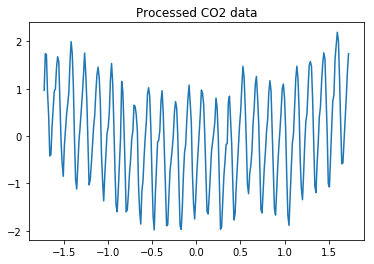

In [3]:
plt.plot(data_train[:, 0], data_train[:, 1]);
plt.title('Processed CO2 data');

In [13]:
class MLP2(nn.Module):
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu'):
        super(MLP2, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('input', nn.Linear(1, hidden_layers[0]))
        if activation == 'relu':
            self.model.add_module('relu0', nn.ReLU())
        elif activation == 'tanh':
            self.model.add_module('tanh0', nn.Tanh())
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=droprate))
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            if activation == 'relu':
                self.model.add_module('relu'+str(i+1), nn.ReLU())
            elif activation == 'tanh':
                self.model.add_module('tanh'+str(i+1), nn.Tanh())
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        return self.model(x)

In [14]:
class MLP2Regressor:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu', \
                 max_epoch=1000000, lr=0.0001, weight_decay=1e-6):
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = MLP2(hidden_layers=hidden_layers, droprate=droprate, activation=activation)
        self.model.cuda()
        self.criterion = nn.MSELoss().cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
    def fit(self, X_train, y_train, verbose=True):
        X = Variable(torch.from_numpy(X_train).type(torch.FloatTensor)).cuda()
        y = Variable(torch.from_numpy(y_train).type(torch.FloatTensor)).cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, loss.item()))
        return self

In [31]:
mlp2 = [MLP2Regressor(activation='relu', max_epoch=100000),
        MLP2Regressor(activation='tanh', max_epoch=100000)]
        
[mlp.fit(X_train, y_train,verbose=False) for mlp in mlp2]

for ind, mlp in enumerate(mlp2):
    torch.save(mlp.model, 'co2_mlp2_'+str(ind)+'.pth')

mlp2_models = [torch.load('co2_mlp2_'+str(ind)+'.pth',map_location={'cuda:0': 'cpu'}) for ind in [0,1]]

MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1024, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (hidden1): Linear(in_features=1024, out_features=1024, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (hidden2): Linear(in_features=1024, out_features=1024, bias=True)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.2, inplace=False)
    (hidden3): Linear(in_features=1024, out_features=1024, bias=True)
    (relu3): ReLU()
    (dropout4): Dropout(p=0.2, inplace=False)
    (hidden4): Linear(in_features=1024, out_features=1024, bias=True)
    (relu4): ReLU()
    (dropout5): Dropout(p=0.2, inplace=False)
    (final): Linear(in_features=1024, out_features=1, bias=True)
  )
)
MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1024, bias=True)
    (tanh0): Tanh()
    (dropout1): Dropout(p=0.2, inplace=False)
    (hidden1): Linear(in_features=1024, out_features=1024, bias=T

/home/dchesakov/.local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MLP2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dchesakov/.local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MLP2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [32]:
def predict_reg(model, X, T=10000):
    X = Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda())
    model = model.train()
    Yt_hat = np.array([model(X).data.cpu().numpy() for _ in range(T)]).squeeze()
    model = model.eval()
    y_pred = model(X).data.cpu().numpy()
    model = model.train()
    return y_pred, Yt_hat

In [33]:

mlp2_models = [torch.load('co2_mlp2_'+str(ind)+'.pth') for ind in [0,1]]
y_relu_pred, y_hat = predict_reg(mlp2_models[0], X_test)
y_relu_mc = y_hat.mean(axis=0)
y_relu_mc_std = y_hat.std(axis=0)
y_tanh_pred, y_hat = predict_reg(mlp2_models[1], X_test)
y_tanh_mc = y_hat.mean(axis=0)
y_tanh_mc_std = y_hat.std(axis=0)
results = [y_relu_pred,y_relu_mc,y_relu_mc_std,y_tanh_pred,y_tanh_mc,y_tanh_mc_std]
results = [x.reshape(-1).astype(str).tolist() for x in results]
open("mlp2_sim_results.txt","w").write('\n'.join([','.join(res) for res in results]))


# Load saved simulation results
results = [res_array.split(',') for res_array in 
                      open("mlp2_sim_results.txt","r").read().split('\n')]
results = np.array(results,dtype='f')
y_relu_pred,y_relu_mc,y_relu_mc_std,y_tanh_pred,y_tanh_mc,y_tanh_mc_std = results

In [34]:
import pickle

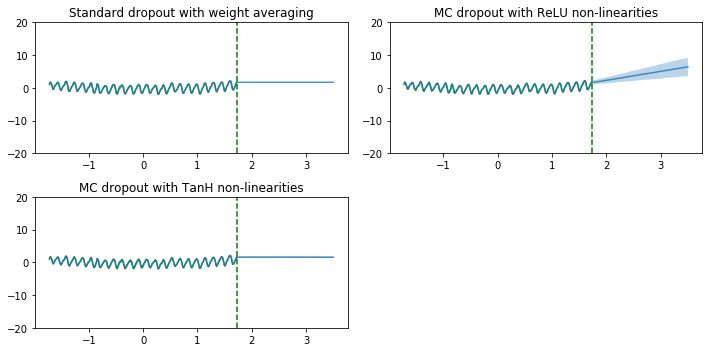

In [37]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.title('Standard dropout with weight averaging');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 2)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_relu_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_relu_mc-2*y_relu_mc_std, y_relu_mc+2*y_relu_mc_std, alpha=0.3);
plt.title('MC dropout with ReLU non-linearities');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 3)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_tanh_mc-2*y_tanh_mc_std, y_tanh_mc+2*y_tanh_mc_std, alpha=0.3);
plt.title('MC dropout with TanH non-linearities');
plt.ylim([-20, 20]);

plt.tight_layout();